# **Data Visualization and Machine Learning (Classification)**

## **Import Libraries**

In [0]:
import pandas as pd
import numpy as np

#For Visualization
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

#For Feature Selection / Importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#For Model Training and Testing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV #Hyperparameter Optimization

#For Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

#For Evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve

In [0]:
#Load the File
url = 'https://raw.githubusercontent.com/jeanmika/shelf/master/advertising_classification.csv?token=AOA2RYVRU7ZYD7Z4LISVFY256KUJQ'
adv_csv = pd.read_csv(url)
data = adv_csv

##**Data Cleaning & Feature Engineering**

In [0]:
#Examine the Numerical Variables
data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


Observations:

*   For "Daily Time Spent on Internet" the mean is 65, median is 68.2, which suggests that the this is slightly negatively skewed.
*   For "Age", the mean is 36, median is 35; this suggests that Age is a normal distribution (very slightly positively skewed). Min age of 19 and max age of 61 suggests that the site targets the adults.
*   For "Area Income", mean is 55k, median is 57k, suggesting a negatively skewed distribution. There is also a huge margin between the max value (80k) and the min value (14k).
*   For "Daily Internet Usage", mean is 180, median is 183.2, suggesting a slightly negatively skewed distribution.
*   For "Male", the mean is 0.481, which means there are more female entires.
*   For "Clicked on Ad", a mean of 0.5 states that there is an equal number of users who clicked and users who did not clicked the ad; thus the dataset is balanced.


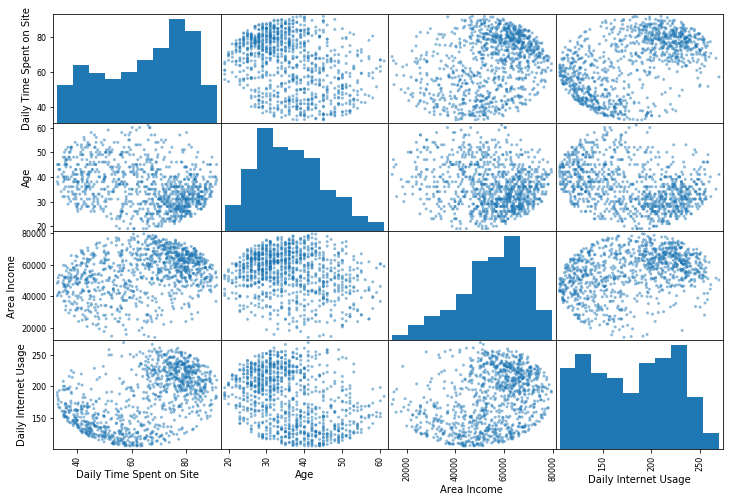

In [0]:
#Create scatter plot to confirm observations and analyze further
num_var = ['Daily Time Spent on Site', 'Age','Area Income', 'Daily Internet Usage']
scatter_matrix(data[num_var], alpha=0.5, figsize=(12,8));

In order to click an ad, the user first has to spend time on the site, thus, we examine the correlations of "Daily time spent on site":
*   (vs Age) There is a cluster of users between age 19 to 40 who spend a significant amount of time on the site.
*   (vs Area Income) Similarly, there is a cluster of people with high area income (between 50k to 80k) spending a lot of time in the site.
*   (vs Daily Internet Usage) Most of the site's mainstays are those who also spend more time in the internet.

Text(0.5, 0.98, 'No Click')

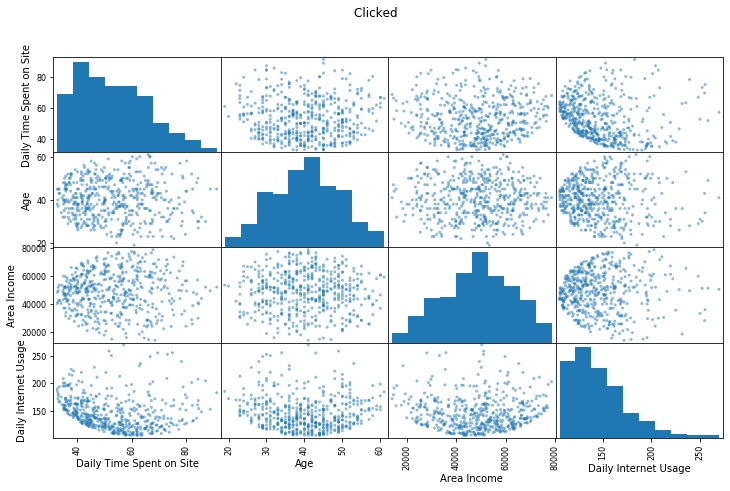

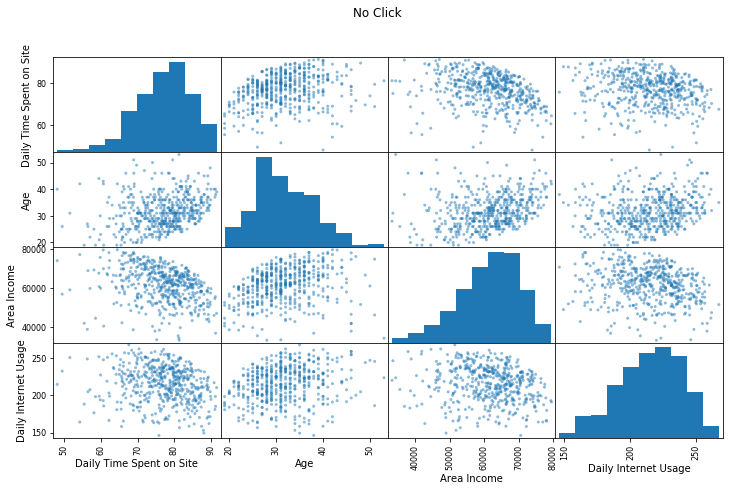

In [0]:
#Separately examine the data of those who clicked and did not click
dataclk = data[data['Clicked on Ad'] == 1]
datanoclk = data[data['Clicked on Ad'] != 1]
scatter_matrix(dataclk[num_var], alpha=0.5, figsize=(12,7));
plt.suptitle('Clicked \n\n\n')

scatter_matrix(datanoclk[num_var], alpha=0.5, figsize=(12,7));
plt.suptitle('No Click')

Based on the scatter marix above, we can infer that most of those who clicked:

*   spent relatively less time on the site per day (high density from 0 to 60 minutes)
*   have varied age (high density within the 30 to 50 age range)
*   have varied area income (high density on 40K - 60K range, but still dispersed)
*   spent relatively less time in the internet per day (high density from 0 t0 150 minutes)

The distribution of people who clicked are mostly normal, while those who didn't click are skewed. 
Those who didn't click show moderate to strong correlation among their variables.

In [0]:
#Examine the Categorical Variables
cat_var = ['Ad Topic Line','Country','City']
data[cat_var].describe()

,Ad Topic Line,Country,City
count,1000,1000,1000
unique,1000,237,969
top,Cross-group human-resource time-frame,France,Williamsport
freq,1,9,3


For categorical data, the way to include them in the analysis is by making a dummy numerical variable for each unique keywords found. But before we do that, we must first assess if doing so would have relevant results.

Observations:
*   "Ad Topic Line" has 1000 out of 1000 unique keys; City has 969 out of 1000 unique keys; Both of these categories will not help our machine learning model find a pattern, thus they should be disregarded.
*   Country has 237 out of 1000 unique keys, which means that some of these keys
keys repeat themselves; however, the highest frequency of one key appearing
is only 9 times (not quite a dominating value). Thus, this will not be helpful to our model's training as well, and would be better off removed.

In [0]:
#Expand Timestamp variable (month, date, and time might help the model)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['Month'] = data['Timestamp'].dt.month
data['Day (month)'] = data['Timestamp'].dt.day
data['Day (week)'] = data['Timestamp'].dt.dayofweek
data['Hour'] = data['Timestamp'].dt.hour

In [0]:
#Remove the unnecessary variables
data = data.drop(cat_var, axis=1)
data = data.drop(['Timestamp'], axis=1)
data

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Month,Day (month),Day (week),Hour
0,68.95,35,61833.90,256.09,0,0,3,27,6,0
1,80.23,31,68441.85,193.77,1,0,4,4,0,1
2,69.47,26,59785.94,236.50,0,0,3,13,6,20
3,74.15,29,54806.18,245.89,1,0,1,10,6,2
4,68.37,35,73889.99,225.58,0,0,6,3,4,3
...,...,...,...,...,...,...,...,...,...,...
995,72.97,30,71384.57,208.58,1,1,2,11,3,21
996,51.30,45,67782.17,134.42,1,1,4,22,4,2
997,51.63,51,42415.72,120.37,1,1,2,1,0,17
998,55.55,19,41920.79,187.95,0,0,3,24,3,2


##**Feature Selection / Importance**

Here, we employ univariate selection using the SelectKBest function to observe the features with the best relationship to our target outcome. We use the chi-squared statistical test.

In [0]:
#Separate the features from the outcome
X = data.drop(['Clicked on Ad'], axis=1)  #Columns of all features
y = data['Clicked on Ad']    #Column of target (Clicked or Not)

#Apply SelectKBest
bestfeat = SelectKBest(score_func=chi2, k='all')
fit = bestfeat.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#Concatenate the dataframes for visualization 
featscores = pd.concat([dfcolumns,dfscores],axis=1)
featscores.columns = ['Specs','Score']
featscores.nlargest(X.shape[1],'Score')

,Specs,Score
2,Area Income,741376.597205
3,Daily Internet Usage,6617.726024
0,Daily Time Spent on Site,2161.951402
1,Age,519.470827
8,Hour,9.339623
4,Male,0.750520
5,Month,0.251768
6,Day (month),0.136657
7,Day (week),0.005222


Based on the results above, the features with significantly better relationships with the outcome are "Area Income", "Daily Internet Usage", "Daily Time Spent on Site", and "Age". "Hour" comes fifth, but its score is rather low, thus we omit this feature, along with the other features below it.





In [0]:
#Take the best features
X_n = X[['Area Income','Daily Internet Usage','Daily Time Spent on Site','Age']]

Alternatively, we can use tree-based classifiers to use a built in class called "Feature Importance". As seen in the graph below, the hierarchy of importance differ from the univariate selection's output, but the top four features remain the same.

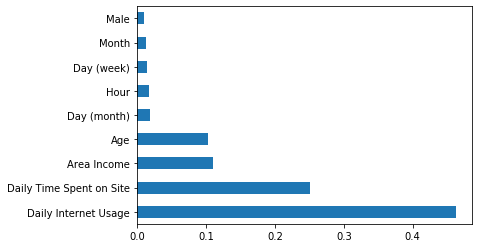

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X,y)

#Plot
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

##**Model Selection**

Tested here are three common classifiers used in binary classification problems:

*   Gaussian Naive-Bayes
*   Decision Tree
*   Logistic Regression

Each model is cross-validated in its default setting.

In [0]:
#Split the dataset: Training (70%), and Testing (30%)
X_tr, X_te, y_tr, y_te = train_test_split(X_n, y, test_size=0.3, random_state=42, stratify=y)

GNB = GaussianNB()
DTC = DecisionTreeClassifier()
logreg = LogisticRegression(solver='liblinear')

models = [GNB, DTC, logreg]

#Function to get cross validation scores
def get_cv_scores(model):
    scores = cross_val_score(model, X_tr, y_tr, cv=5, scoring='roc_auc')
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

for model in models:
    print(model)
    get_cv_scores(model)

GaussianNB(priors=None, var_smoothing=1e-09)
CV Mean:  0.9893877551020408
STD:  0.006888170811340096


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
CV Mean:  0.9328571428571429
STD:  0.01324802642213672


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
CV Mean:  0.9507755102040816
STD:  0.0238918150312901




Based on the results of the cross validation, the Gaussian Naive Bayes are the best ones for this dataset. Since the Gaussian Naive Bayes don't have much to tune, we instead tune the second best, Logistic Regression Classifier, just to see if it will perform better than Gaussian Naive Bayes once tuned.

## **Hyperparameter Optimization**

In [0]:
#Hyperparameter Optimization for Lorgistic Regression
penalty = ['l1','l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver = ['liblinear']

param_grid = dict(penalty=penalty, C=C, solver=solver)

grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='roc_auc',cv=3)
grid_result = grid.fit(X_tr, y_tr)

print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)

c = grid_result.best_params_['C']
solverr = grid_result.best_params_['solver']
penaltyy = grid_result.best_params_['penalty']

Best Score:  0.9907947033809102
Best Params:  {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


## **Model Metrics**

These section shows the performance of the chosen model, GaussianNB and Logistic Regression. For Logistic Regression, the performances of both untuned and tuned model are shown for comparison. While GaussianNB has better performance by default, the tuned Logistic Regression Classifier beats it by a few percentage. 

In [0]:
#Performance of Each Model
model_1 = GaussianNB()
model_1.fit(X_tr, y_tr)
pred_GNB = model_1.predict(X_te)
print('Gaussian Naive Bayes ROC-AUC:', roc_auc_score(pred_GNB, y_te))
print('Gaussian Naive Bayes Accuracy:', accuracy_score(pred_GNB, y_te))
print('Gaussian Naive Bayes Recall:', recall_score(pred_GNB, y_te))
print('Gaussian Naive Bayes Precision:', precision_score(pred_GNB, y_te))
print('Confusion matrix:')
print(confusion_matrix(y_te,pred_GNB))
print('\n')

model_2 = LogisticRegression(solver='liblinear')
model_2.fit(X_tr, y_tr)
pred_LR = model_2.predict(X_te)
print('Logistic regression (untuned) ROC-AUC:', roc_auc_score(pred_LR, y_te))
print('Logistic regression (untuned) Accuracy:', accuracy_score(pred_LR, y_te))
print('Logistic regression (untuned) Recall:', recall_score(pred_LR, y_te))
print('Logistic regression (untuned) Precision:', precision_score(pred_LR, y_te))
print('Confusion matrix:')
print(confusion_matrix(y_te,pred_LR))
print('\n')

model_3 = LogisticRegression(solver=solverr, C=c, penalty=penaltyy)
model_3.fit(X_tr, y_tr)
pred_LR2 = model_3.predict(X_te)
print('Logistic regression (tuned) ROC-AUC:', roc_auc_score(pred_LR2, y_te))
print('Logistic regression (tuned) Accuracy:', accuracy_score(pred_LR2, y_te))
print('Logistic regression (tuned) Recall:', recall_score(pred_LR2, y_te))
print('Logistic regression (tuned) Precision:', precision_score(pred_LR2, y_te))
print('Confusion matrix:')
print(confusion_matrix(y_te,pred_LR2))
print('\n')

Gaussian Naive Bayes ROC-AUC: 0.9733333333333334
Gaussian Naive Bayes Accuracy: 0.9733333333333334
Gaussian Naive Bayes Recall: 0.9733333333333334
Gaussian Naive Bayes Precision: 0.9733333333333334
Confusion matrix:
[[146   4]
 [  4 146]]


Logistic regression (untuned) ROC-AUC: 0.8980998260404122
Logistic regression (untuned) Accuracy: 0.8966666666666666
Logistic regression (untuned) Recall: 0.9219858156028369
Logistic regression (untuned) Precision: 0.8666666666666667
Confusion matrix:
[[139  11]
 [ 20 130]]


Logistic regression (tuned) ROC-AUC: 0.980085348506401
Logistic regression (tuned) Accuracy: 0.98
Logistic regression (tuned) Recall: 0.9864864864864865
Logistic regression (tuned) Precision: 0.9733333333333334
Confusion matrix:
[[148   2]
 [  4 146]]




## **Reference:**

**For Data Analysis and Engineering**
*   https://stackabuse.com/predicting-customer-ad-clicks-via-machine-learning/

**For Selecting Features**

*   https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

**For Model Selection and Hyperparameter Oprimization**

*   https://towardsdatascience.com/hyperparameter-tuning-c5619e7e6624
*   https://www.kaggle.com/tboyle10/hyperparameter-tuning
*   https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

**Documentation**
*   https://scikit-learn.org/stable/index.html
